In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


### load packages

In [3]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [5]:
from tensorflow.keras.datasets import mnist

In [6]:
# load dataset
(train_images, Y_train), (test_images, Y_test) = mnist.load_data()
X_train = (train_images/255.).astype('float32')
X_test = (test_images/255.).astype('float32')
X_train = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

# subset a validation set
n_valid = 10000
X_valid = X_train[-n_valid:]
Y_valid = Y_train[-n_valid:]
X_train = X_train[:-n_valid]
Y_train = Y_train[:-n_valid]

# flatten X
X_train_flat = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test_flat = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
X_valid_flat= X_valid.reshape((len(X_valid), np.product(np.shape(X_valid)[1:])))
print(len(X_train), len(X_valid), len(X_test))

50000 10000 10000


### Create model and train

In [7]:
embedder = tfUMAP(n_components = 64, direct_embedding=True, verbose=True, negative_sample_rate=5, training_epochs=100)

In [8]:
z = embedder.fit_transform(X_train_flat)

tfUMAP(direct_embedding=True, negative_sample_rate=5,
       optimizer=<tensorflow.python.keras.optimizer_v2.adadelta.Adadelta object at 0x7f2d82809b70>,
       tensorboard_logdir='/tmp/tensorboard/20200714-102407',
       training_epochs=100)
Construct fuzzy simplicial set
Tue Jul 14 10:24:08 2020 Finding Nearest Neighbors
Tue Jul 14 10:24:08 2020 Building RP forest with 16 trees
Tue Jul 14 10:24:11 2020 parallel NN descent for 16 iterations
	 0  /  16
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
Tue Jul 14 10:24:25 2020 Finished Nearest Neighbor Search
Tue Jul 14 10:24:48 2020 Embedding with TensorFlow


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Tue Jul 14 10:30:52 2020 Finished embedding


### Plot model output

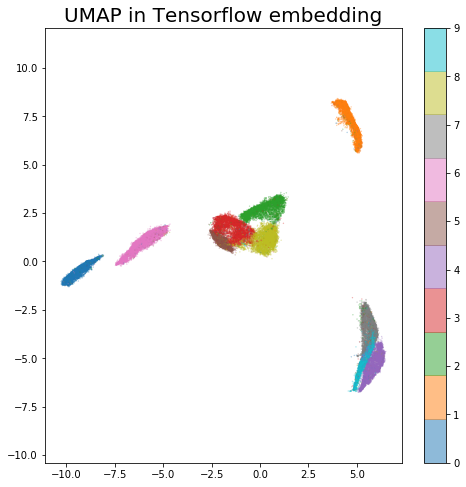

In [9]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### View loss

In [10]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

In [11]:
loss_df = retrieve_tensors(embedder.tensorboard_logdir)
loss_df[:3]

['umap_loss']
[]


,wall_time,step,val,group,variable
0,1.594747e+09,1,0.223925,train,umap_loss
1,1.594747e+09,2,0.233880,train,umap_loss
2,1.594747e+09,3,0.233285,train,umap_loss


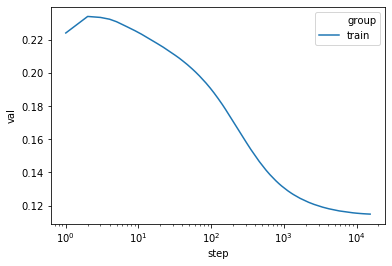

In [12]:
ax = sns.lineplot(x="step", y="val", hue="group", data=loss_df[loss_df.variable=='umap_loss'])
ax.set_xscale('log')

### Save output

In [13]:
from tfumap.paths import ensure_dir, MODEL_DIR

In [14]:
output_dir = MODEL_DIR/'projections'/ 'mnist' / '64'/ 'direct'
ensure_dir(output_dir)

In [15]:
embedder.save(output_dir)

Pickle of model saved


In [16]:
loss_df.to_pickle(output_dir / 'loss_df.pickle')

In [17]:
np.save(output_dir / 'z.npy', z)